In [1]:
import torch

import torch.nn as nn

import piq

In [2]:
cuda0 = torch.device('cuda:0')

print(cuda0)

cuda:0


In [3]:
class AutoEnc(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 3, (5, 5), padding=2)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.s = nn.Sigmoid()
        
        self.upsample = nn.Upsample(scale_factor=4)
        
    def forward(self, inp):
        
        x = self.conv1(inp.float())
        x = self.pool1(x)
        x = self.conv1(x)
        x = self.pool1(x)
        
        #x = self.s(x)
         
        x = self.upsample(x)
        x = self.pool1(x)
        x = self.upsample(x)
        x = self.pool1(x)
        x = self.s(x)
        
        return x

autoenc = AutoEnc().to(cuda0)

RuntimeError: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

#### Read Images

  0%|          | 0/1489 [00:00<?, ?it/s]

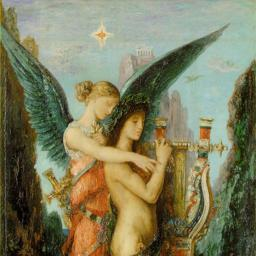

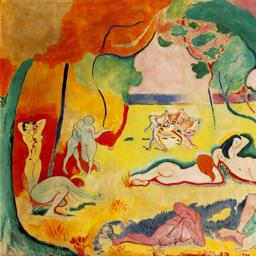

(1455, 256, 256, 3)


In [4]:
import os
from PIL import Image
import numpy as np
import IPython.display as display
import tqdm.notebook as tqdm

t = tqdm.tqdm(total=1489)

def read_images(image_dir):
    data = []
    for file in os.listdir(image_dir):
        im = Image.open(image_dir + file)
        arr = np.array(im.getdata())
        t.update(1)
        if len(arr.shape) < 2 or arr.shape[1] < 3:
            continue
        data.append(np.array(im.getdata()).reshape((256,256,3))/255.0)
        if len(data)<6:
            display.display(im)
    data = np.array(data)
    return data

image_dir = '../DeepPainter/ImagesNorm/'

data = read_images(image_dir)

print(data.shape)

In [14]:
criterion = piq.SSIMLoss()

In [28]:
optimizer = torch.optim.Adam(autoenc.parameters(), lr=0.0001)

def train(img):
    autoenc.zero_grad()
    output = autoenc(img)

    loss = criterion(output, img)
    
    loss.backward()
    
    optimizer.step()
    
    return loss.item()

In [ ]:
import time
import math

n_iters = 20000
print_every = 1000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
print(data.shape)
for iter in range(1, n_iters + 1):
    img = torch.tensor(data[iter % data.shape[0]]).transpose(0, 2).reshape(1, 3, 256, 256).float()
    loss = train(img)
    current_loss += loss
    
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f' % (iter, iter/n_iters*100, timeSince(start), current_loss/plot_every))
        
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

(1455, 256, 256, 3)
1000 5% (0m 42s) 0.6346
2000 10% (1m 24s) 0.5616
3000 15% (2m 7s) 0.5170
4000 20% (2m 51s) 0.4881
5000 25% (3m 36s) 0.4679
6000 30% (4m 19s) 0.4600
7000 35% (5m 4s) 0.4523
8000 40% (5m 44s) 0.4422
9000 45% (6m 25s) 0.4466


In [115]:
plt.plot(range(len(all_losses)), all_losses)

In [129]:
from torchsummary import summary

summary(autoenc, (3, 256, 256))

RuntimeError: Given groups=1, weight of size [3, 2, 5, 5], expected input[2, 3, 256, 256] to have 2 channels, but got 3 channels instead

In [116]:
nimg = autoenc(torch.tensor(data[:5]).transpose(1, 3))

In [117]:
import matplotlib.pyplot as plt

plt.imshow(nimg[4].transpose(0, 2).detach().numpy())

In [118]:
plt.imshow(data[4])

In [17]:
autoenc(torch.tensor(data[:1]).transpose(1, 3))

tensor([[[[-0.0729, -0.0729, -0.0729,  ..., -0.1384, -0.1384, -0.1384],
          [-0.0729, -0.0729, -0.0729,  ..., -0.1384, -0.1384, -0.1384],
          [-0.0729, -0.0729, -0.0729,  ..., -0.1384, -0.1384, -0.1384],
          ...,
          [-0.2343, -0.2343, -0.2343,  ..., -0.1028, -0.1028, -0.1028],
          [-0.2343, -0.2343, -0.2343,  ..., -0.1028, -0.1028, -0.1028],
          [-0.2343, -0.2343, -0.2343,  ..., -0.1028, -0.1028, -0.1028]],

         [[ 0.0317,  0.0317,  0.0317,  ...,  0.1101,  0.1101,  0.1101],
          [ 0.0317,  0.0317,  0.0317,  ...,  0.1101,  0.1101,  0.1101],
          [ 0.0317,  0.0317,  0.0317,  ...,  0.1101,  0.1101,  0.1101],
          ...,
          [ 0.0813,  0.0813,  0.0813,  ...,  0.1104,  0.1104,  0.1104],
          [ 0.0813,  0.0813,  0.0813,  ...,  0.1104,  0.1104,  0.1104],
          [ 0.0813,  0.0813,  0.0813,  ...,  0.1104,  0.1104,  0.1104]],

         [[ 0.1010,  0.1010,  0.1010,  ...,  0.0603,  0.0603,  0.0603],
          [ 0.1010,  0.1010,  